In [1]:
from pathlib import Path
import sys
import pandas as pd
from PIL import Image
import io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from sklearn.model_selection import train_test_split
import torchvision 
from torchvision import transforms
import pickle
from scipy import stats
import numpy as np
from torchvision.models import efficientnet_b3
from mlcroissant import Dataset
import itertools
from datasets import load_dataset
import zipfile
import io

In [2]:
from huggingface_hub import login
login()

In [3]:
class QuadrantSqueezeExcitation(nn.Module):
  def __init__(self, in_channels, reduction_dim):
    super(QuadrantSqueezeExcitation, self).__init__()
    self.avgpool = nn.AdaptiveAvgPool2d((2,2))
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=reduction_dim, kernel_size=(1,1), stride=(1,1))
    self.conv2 = nn.Conv2d(in_channels=reduction_dim, out_channels=in_channels, kernel_size=(1,1), stride=(1,1))
    self.activation = nn.SiLU()
    self.scale_activation = nn.Sigmoid()
  def forward(self, x):
    residual = x.clone()
    b,c,h,w = x.size()
    x = self.avgpool(x)
    x = self.conv1(x)
    x = self.activation(x)
    x = self.conv2(x)
    x = self.scale_activation(x)
    # top left
    residual[:,:,0:int(h/2),0:int(w/2)] = residual[:,:,0:int(h/2),0:int(w/2)].clone() * x[:,:,0:1,0:1]
    # top right
    residual[:,:,0:int(h/2),int(w/2):w] = residual[:,:,0:int(h/2),int(w/2):w].clone() * x[:,:,0:1,1:2]
    # bottom left
    residual[:,:,int(h/2):h,0:int(w/2)] = residual[:,:,int(h/2):h,0:int(w/2)].clone() * x[:,:,1:2,0:1]
    # bottom right
    residual[:,:,int(h/2):h,int(w/2):w] = residual[:,:,int(h/2):h,int(w/2):w].clone() * x[:,:,1:2,1:2]
    return residual

In [4]:
class EfficientNetB3QSE(nn.Module):
  def __init__(self, num_classes, stages):
    super(EfficientNetB3QSE, self).__init__()
    self.model = efficientnet_b3(weights="IMAGENET1K_V1", progress=True)
    self.model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True), 
        nn.Linear(in_features=1536, out_features=num_classes, bias=True)
    )
    for param in self.model.parameters():
        param.requires_grad = False
    for param in self.model.classifier.parameters():
        param.requires_grad = True
    # qse in stage 2
    if 2 in stages:
        self.model.features[1][0].block[1] = QuadrantSqueezeExcitation(40,10)
        self.model.features[1][1].block[1] = QuadrantSqueezeExcitation(24,6)
    # qse in stage 3
    if 3 in stages:
        self.model.features[2][0].block[2] = QuadrantSqueezeExcitation(144,6)
        for i in range(1,3):
          self.model.features[2][1].block[2] = QuadrantSqueezeExcitation(192,8)
    # qse in stage 4
    if 4 in stages:
      self.model.features[3][0].block[2] = QuadrantSqueezeExcitation(192,8)
      for i in range(1,3):  
        self.model.features[3][i].block[2] = QuadrantSqueezeExcitation(288,12)
    # qse in stage 5
    if 5 in stages:
      self.model.features[4][0].block[2] = QuadrantSqueezeExcitation(288,12)
      for i in range(1,5):
        self.model.features[4][i].block[2] = QuadrantSqueezeExcitation(576,24)
    # qse in stage 6
    if 6 in stages:
      self.model.features[5][0].block[2] = QuadrantSqueezeExcitation(576,24)
      for i in range(1,5):
        self.model.features[5][i].block[2] = QuadrantSqueezeExcitation(816,34)
    # qse in stage 7
    if 7 in stages:
      self.model.features[6][0].block[2] = QuadrantSqueezeExcitation(816,34)
      for i in range(1,6):
        self.model.features[6][i].block[2] = QuadrantSqueezeExcitation(1392,58)
    # qse in stage 8
    if 8 in stages:
      self.model.features[7][0].block[2] = QuadrantSqueezeExcitation(1392,58)
      self.model.features[7][1].block[2] = QuadrantSqueezeExcitation(2304,96)
  def forward(self, x):
    return self.model(x)

In [5]:
ds = load_dataset("blanchon/UC_Merced")
df = ds['train'].to_pandas()

In [6]:
# Function to convert zip path to PIL image
def load_image_bytes(image_dict):
    image = Image.open(io.BytesIO(image_dict["bytes"])) 
    if image.mode != 'RGB':
        image = image.convert('RGB')
        
    # Save the image as a JPEG in a BytesIO object
    jpeg_image_io = io.BytesIO()
    image.save(jpeg_image_io, format='JPEG')
    jpeg_image_io.seek(0)  # Reset the stream position to the beginning
    
    # Load the JPEG image from the BytesIO object
    jpeg_image = Image.open(jpeg_image_io)
    return jpeg_image

# Apply the function to the 'image' column
df['image'] = df['image'].apply(load_image_bytes)

In [7]:
df.head()

,image,label
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0


In [8]:
label = {
    0:"agriculture",
    1:"airplane",
    2:"baseballdiamond",
    3:"beach",
    4:"buildings",
    5:"chaparral",
    6:"denseresidential",
    7:"forest",
    8:"freeway",
    9:"golfcourse",
    10:"harbour",
    11:"intersection",
    12:"mediumresidential",
    13:"mobilehomepark",
    14:"overpass",
    15:"parkinglot",
    16:"river",
    17:"runway",
    18:"sparseresidential",
    19:"storagetanks",
    20:"tenniscourt"
}

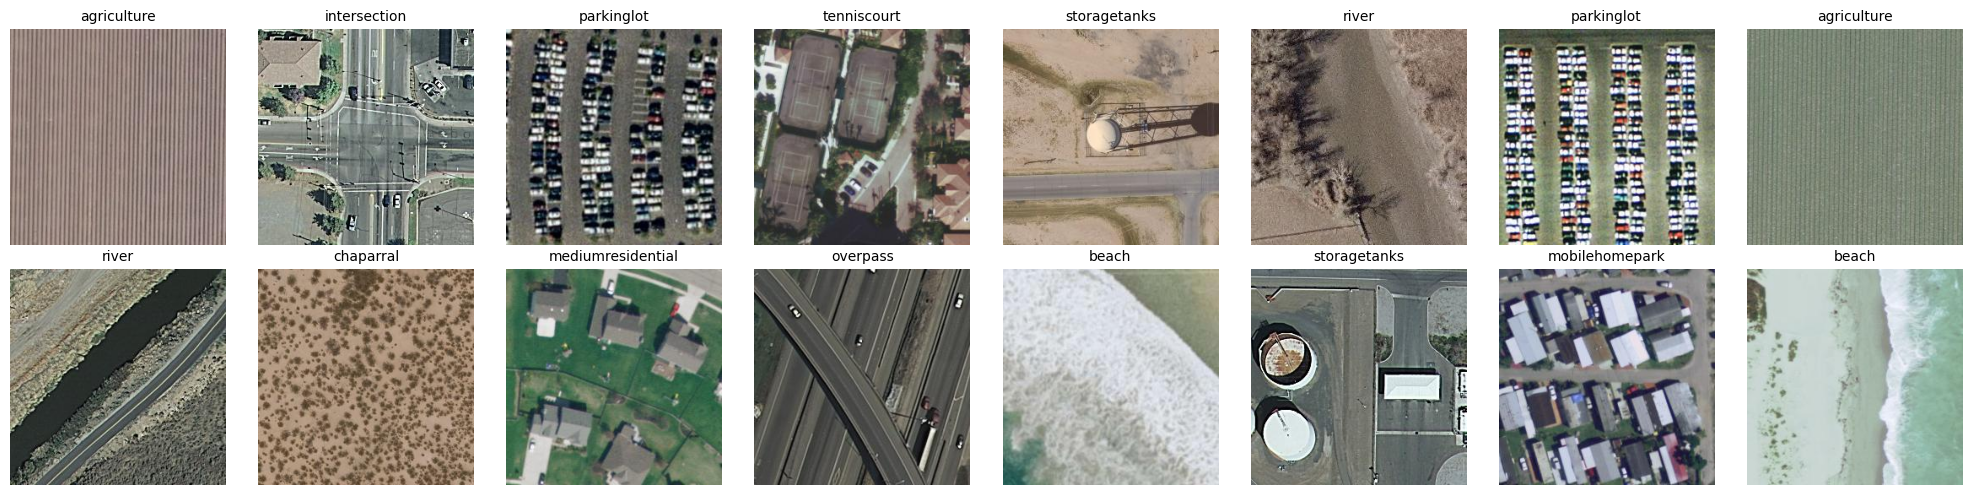

In [9]:
sampled_df = df.sample(n=16)
fig, axes = plt.subplots(2, 8, figsize=(20, 5))
axes = axes.ravel()
for i, (index, row) in enumerate(sampled_df.iterrows()):
    img = row['image']
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(label[row['label']], fontsize=10)  
plt.tight_layout()
plt.show()

In [10]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),  # Resize to 256x256
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=(-180, 180)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),  # Resize to 256x256
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [11]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, scheduler, best_model_params_path, best_accuracy):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    since = time.time()
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        if epoch == 10:
            for param in model.parameters():
                param.requires_grad = True
        # print(f'Epoch {epoch+1}/{num_epochs}')
        # print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                for param in model.parameters():
                    param.grad = None

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            if phase == "train":
                train_accuracies.append(epoch_acc)
            else:
                val_accuracies.append(epoch_acc)

            # print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_accuracy:
                best_accuracy = epoch_acc
                if best_model_params_path != None:
                    torch.save(model.state_dict(), best_model_params_path)
                    # print(f"Current Best Accuracy:{best_accuracy}")

        # print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {max(tensor.cpu().item() for tensor in val_accuracies):4f}')

    return train_accuracies, val_accuracies, best_accuracy

In [12]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img = self.dataframe.iloc[idx]['image']
        label = self.dataframe.iloc[idx]['label']
        if self.transform:
            img = self.transform(img)
        return img, label

In [13]:
# hyperparameters follow the efficientnetb3attn paper
def main(stages, test_size, results_path):
    X = df["image"]
    y = df["label"]
    accuracies_dict = {}
    accuracies_dict["train"] = []
    accuracies_dict["val"] = []
    best_accuracy = 0.0
    for i in range(20):
        print("-"*10)
        print(f"Iteration: {i+1}")
        print("-"*10)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, stratify=y)
        train_dataset = ImageDataset(dataframe=pd.concat([X_train, y_train], axis=1), transform=data_transforms["train"])
        val_dataset = ImageDataset(dataframe=pd.concat([X_val, y_val], axis=1), transform=data_transforms["val"])
        dataloaders = {}
        dataloaders["train"] = DataLoader(train_dataset, batch_size=32, shuffle=True)
        dataloaders["val"] = DataLoader(val_dataset, batch_size=32, shuffle=True)
        criterion = nn.CrossEntropyLoss()
        model = EfficientNetB3QSE(num_classes=21, stages=stages)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75], gamma=0.1)
        NUM_EPOCHS = 40
        best_model_params_path = "./best_model_parameters.pth"
        train_accuracies, val_accuracies, best_accuracy = train_model(model, dataloaders, criterion, optimizer, NUM_EPOCHS, scheduler, best_model_params_path, best_accuracy)
        accuracies_dict["train"].append(train_accuracies)
        accuracies_dict["val"].append(val_accuracies)
    with open(results_path, 'wb') as file:
        pickle.dump(accuracies_dict, file)

In [14]:
def visualize_training_results(data):
    num_rounds = 5
    num_epochs = 50
    
    # Create subplots
    fig, axes = plt.subplots(num_rounds, 1, figsize=(10, 15))
    
    for i in range(num_rounds):
        # Extract training and validation data for the current round
        train_data = data['train'][i]
        val_data = data['val'][i]

        # Move tensors to CPU and convert to numpy
        train_data_cpu = [tensor.cpu().item() for tensor in train_data]
        val_data_cpu = [tensor.cpu().item() for tensor in val_data]

        # Plotting
        axes[i].plot(train_data_cpu, label='Train', color='blue', marker='o')
        axes[i].plot(val_data_cpu, label='Validation', color='orange', marker='x')
        
        # Adding titles and labels
        axes[i].set_title(f'Round {i + 1}')
        axes[i].set_xlabel('Epochs')
        axes[i].set_ylabel('Accuracy')
        axes[i].set_xticks(range(num_epochs))
        axes[i].set_xticklabels(range(1, num_epochs + 1))
        axes[i].legend()
        axes[i].grid()

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [15]:
# internal function
def calculate_max_val_accuracy(data):
    max_val_accuracies = []
    for val in data['val']:
        max_accuracy = max(tensor.cpu().item() for tensor in val)  # Get max accuracy for this iteration
        max_val_accuracies.append(max_accuracy)

    return max_val_accuracies

def calculate_margin_of_error(data, alpha):
    max_val_accuracies = calculate_max_val_accuracy(data)
    mean_val_accuracy = np.mean(max_val_accuracies)
    std_dev = np.std(max_val_accuracies, ddof=1)  # Sample standard deviation
    n = len(max_val_accuracies)  # Number of iterations

    # T-score for 95% confidence level
    t_score = stats.t.ppf(1-alpha/2, df=n-1)  # Two-tailed test, df = n - 1

    # Calculate margin of error
    margin_of_error = t_score * (std_dev / np.sqrt(n))

    return mean_val_accuracy, margin_of_error

In [16]:
results_path = "./train_val_accuracy_log.pkt"
test_size = 0.5
stages = [2,3,4,5,6,7,8]
main(stages, test_size, results_path)

----------
Iteration: 1
----------
Training complete in 8m 53s
Best val Acc: 0.986667
----------
Iteration: 2
----------
Training complete in 9m 24s
Best val Acc: 0.976190
----------
Iteration: 3
----------
Training complete in 9m 34s
Best val Acc: 0.980000
----------
Iteration: 4
----------
Training complete in 9m 34s
Best val Acc: 0.986667
----------
Iteration: 5
----------
Training complete in 9m 31s
Best val Acc: 0.966667
----------
Iteration: 6
----------
Training complete in 9m 32s
Best val Acc: 0.980952
----------
Iteration: 7
----------
Training complete in 8m 24s
Best val Acc: 0.975238
----------
Iteration: 8
----------
Training complete in 7m 58s
Best val Acc: 0.978095
----------
Iteration: 9
----------
Training complete in 7m 58s
Best val Acc: 0.980000
----------
Iteration: 10
----------
Training complete in 7m 60s
Best val Acc: 0.982857
----------
Iteration: 11
----------
Training complete in 7m 59s
Best val Acc: 0.974286
----------
Iteration: 12
----------
Training complet

In [17]:
with open(results_path, 'rb') as file: 
    data = pickle.load(file)
#visualize_training_results(data)

/home/FYP/fooj0029/.conda/envs/test/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [18]:
mean_val, margin_of_error = calculate_margin_of_error(data, 0.05)
print(f"Mean Highest Validation Accuracy: {mean_val}")
print(f"Margin of Error: {margin_of_error}")

Mean Highest Validation Accuracy: 0.9797142857142858
Margin of Error: 0.00272894075228813
